In [1]:
import torch
import os
from PIL import Image
from pathlib import Path
import pandas as pd
import torchvision
from sklearn.model_selection import train_test_split

In [2]:
labels=pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
train,valid=train_test_split(labels,train_size=0.8,shuffle=True,stratify=labels['breed'],random_state=42)

In [3]:
train,train_labels=train['id'].reset_index(drop=True),train['breed'].reset_index(drop=True)
val,val_labels=valid['id'].reset_index(drop=True),valid['breed'].reset_index(drop=True)

In [4]:
'''Encoding labels'''

breeds=dict()
breed_count=1

for breed in labels['breed'].value_counts().index:

    breeds[breed]=breed_count-1
    breed_count+=1

val_labels_torch=torch.zeros(len(val_labels),1)
train_labels_torch=torch.zeros(len(train_labels),1)

for index in val_labels.index:
    val_labels_torch[index]=breeds[val_labels.iloc[index]]

for index in train_labels.index:
    train_labels_torch[index]=breeds[train_labels.iloc[index]]

val_labels_torch = val_labels_torch.long()
train_labels_torch = train_labels_torch.long()


val_labels_torch[91]
# val_labels=torch.tensor(val_labels.values)
# train_labels=torch.tensor(train_labels.values)

tensor([21])

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor()
])


def create_dataset(series, directory_path, transform):
    tensors = []
    for i in range(len(series)):
        if(series[i].endswith('.jpg')):
            img_file=series[i]
        else:
            img_file = series[i] + '.jpg'
        img_path = os.path.join(directory_path, img_file)
        img = Image.open(img_path).convert('RGB')  # Ensure RGB
        img_t = transform(img)
        tensors.append(img_t)
    return torch.stack(tensors, dim=0)


In [6]:
directory_path=Path('/kaggle/input/dog-breed-identification/train')
train_dataset=create_dataset(train,directory_path,transform)

In [7]:


# For validation: no augmentation
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
val_dataset = create_dataset(val, directory_path, transform=val_transform)


In [8]:
from torch.utils.data import TensorDataset

train_dataset_torch=TensorDataset(train_dataset,train_labels_torch)
val_dataset_torch=TensorDataset(val_dataset,val_labels_torch)

In [9]:
train_dataset.shape,train_labels_torch.shape

(torch.Size([8177, 3, 224, 224]), torch.Size([8177, 1]))

In [10]:
val_dataset_torch[0]

(tensor([[[0.2980, 0.2667, 0.1569,  ..., 0.2510, 0.0471, 0.0353],
          [0.2275, 0.1490, 0.2157,  ..., 0.1020, 0.0196, 0.0078],
          [0.2000, 0.1098, 0.2745,  ..., 0.0510, 0.0275, 0.0157],
          ...,
          [0.1176, 0.2118, 0.1843,  ..., 0.1176, 0.1373, 0.1451],
          [0.1490, 0.1843, 0.1804,  ..., 0.1765, 0.1569, 0.1451],
          [0.2431, 0.2784, 0.2118,  ..., 0.1529, 0.1216, 0.1059]],
 
         [[0.3765, 0.3373, 0.2275,  ..., 0.2863, 0.0549, 0.0314],
          [0.3137, 0.2314, 0.2980,  ..., 0.1373, 0.0275, 0.0039],
          [0.2941, 0.2039, 0.3647,  ..., 0.0824, 0.0392, 0.0157],
          ...,
          [0.1176, 0.2118, 0.1882,  ..., 0.1333, 0.1529, 0.1608],
          [0.1490, 0.1843, 0.1843,  ..., 0.1843, 0.1647, 0.1529],
          [0.2431, 0.2784, 0.2157,  ..., 0.1569, 0.1255, 0.1059]],
 
         [[0.3765, 0.3608, 0.2588,  ..., 0.2235, 0.0431, 0.0510],
          [0.2667, 0.2000, 0.2706,  ..., 0.0745, 0.0157, 0.0235],
          [0.1961, 0.1176, 0.2902,  ...,

In [11]:
from torchvision.models import resnext101_32x8d, ResNeXt101_32X8D_Weights
import torch.nn as nn
import torch.optim as optim

resnet = resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1)
for param in resnet.parameters():
    param.requires_grad = False


resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),  # From ResNet's output to 256 units
    nn.ReLU(),                              # Activation function
    nn.BatchNorm1d(256),                    # Normalization for stability
    nn.Linear(256, 256),                    # Additional dense layer
    nn.ReLU(),                              # Activation again
    nn.Dropout(0.3),                        # Dropout to reduce overfitting
    nn.BatchNorm1d(256),                    # Another batch norm layer
    nn.Linear(256, 120)                     # Final layer: 120 output classes
)
model_torch = resnet

optimizier=optim.Adam(model_torch.parameters(),lr=1e-4)
loss_fn=nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:01<00:00, 203MB/s]  


In [30]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

train_loader = DataLoader(train_dataset_torch, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset_torch,   batch_size=64, shuffle=False)
n_epochs = 20
model_torch = model_torch.to('cuda')

train_losses = []
val_losses   = []
accuracies   = []

for i in range(1, n_epochs+1):
    #訓練階段
    model_torch.train()
    training_loss = 0.0
    for img, label in train_loader:
        img   = img.to('cuda')
        label = label.to('cuda').squeeze(1)
        optimizier.zero_grad()
        outputs = model_torch(img)
        losses  = loss_fn(outputs, label)
        training_loss += losses.item()
        losses.backward()
        optimizier.step()
    avg_train_loss = training_loss / len(train_loader)

    # 驗證階段
    model_torch.eval()
    val_loss = 0.0
    correct  = 0
    total    = 0

    all_labels = []  # 用來收集所有真實標籤
    all_preds  = []  # 用來收集所有預測標籤

    with torch.no_grad():
        for img, label in val_loader:
            img    = img.to('cuda')
            label  = label.to('cuda').squeeze(1)
            outputs = model_torch(img)
            loss    = loss_fn(outputs, label)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total   += label.size(0)
            correct += (predicted == label).sum().item()

            # 收集這個 batch 的標籤與預測
            all_labels.extend(label.cpu().numpy())
            all_preds .extend(predicted.cpu().numpy())

    # 計算平均驗證損失與準確率
    avg_val_loss = val_loss / len(val_loader)
    accuracy     = 100 * correct / total

    cm = confusion_matrix(all_labels, all_preds)
    errors_per_class = cm.sum(axis=1) - np.diag(cm)
    worst_class = np.argmax(errors_per_class)
    print(f"→ 錯誤最多的類別：{worst_class}，錯誤次數：{errors_per_class[worst_class]}")

    # 存儲並印出這個 epoch 的結果
    train_losses.append(avg_train_loss)
    val_losses  .append(avg_val_loss)
    accuracies  .append(accuracy)
    print(f"Epoch [{i}/{n_epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")


→ 錯誤最多的類別：118，錯誤次數：10
Epoch [1/20], Training Loss: 0.1363, Validation Loss: 0.4310, Accuracy: 88.51%
→ 錯誤最多的類別：118，錯誤次數：12
Epoch [2/20], Training Loss: 0.1248, Validation Loss: 0.4361, Accuracy: 88.36%
→ 錯誤最多的類別：118，錯誤次數：11
Epoch [3/20], Training Loss: 0.1114, Validation Loss: 0.4335, Accuracy: 87.92%
→ 錯誤最多的類別：77，錯誤次數：10
Epoch [4/20], Training Loss: 0.1030, Validation Loss: 0.4256, Accuracy: 88.56%
→ 錯誤最多的類別：118，錯誤次數：11
Epoch [5/20], Training Loss: 0.0943, Validation Loss: 0.4302, Accuracy: 88.41%
→ 錯誤最多的類別：118，錯誤次數：12
Epoch [6/20], Training Loss: 0.0871, Validation Loss: 0.4328, Accuracy: 87.97%
→ 錯誤最多的類別：118，錯誤次數：11
Epoch [7/20], Training Loss: 0.0755, Validation Loss: 0.4240, Accuracy: 88.26%
→ 錯誤最多的類別：18，錯誤次數：10
Epoch [8/20], Training Loss: 0.0735, Validation Loss: 0.4391, Accuracy: 88.12%
→ 錯誤最多的類別：118，錯誤次數：9
Epoch [9/20], Training Loss: 0.0667, Validation Loss: 0.4182, Accuracy: 88.41%
→ 錯誤最多的類別：118，錯誤次數：12
Epoch [10/20], Training Loss: 0.0608, Validation Loss: 0.4432, Accuracy:

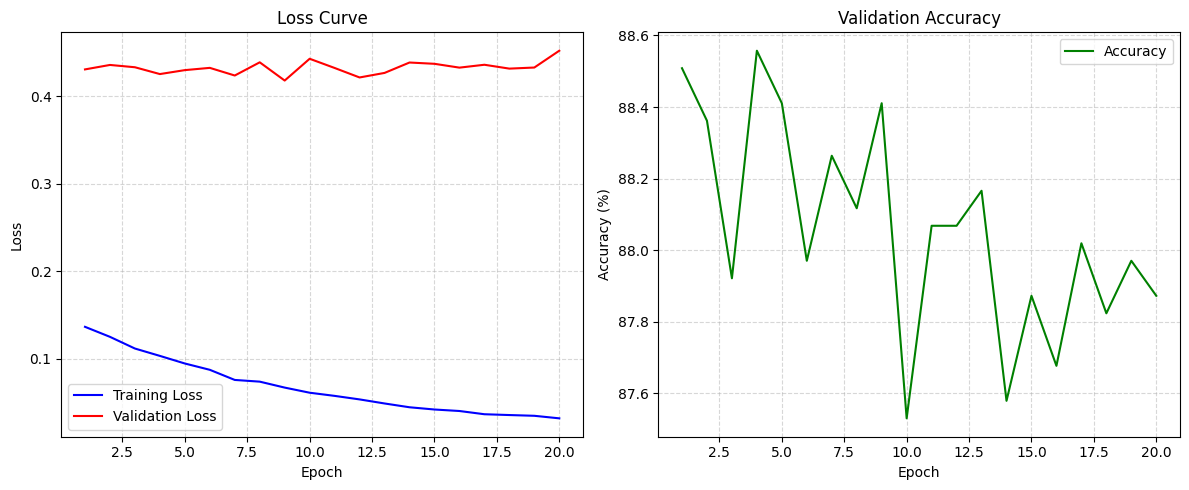

In [31]:
# 繪製損耗和準確率曲線
plt.figure(figsize=(12, 5))

# 損失
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, n_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 準確率
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), accuracies, 'g-', label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')  # 保存圖片
plt.show()

In [15]:
torch.save(resnet.state_dict(), 'resnet_custom_head.pth')


In [17]:
os.listdir('/kaggle/input/dog-breed-identification/test')[1:10]

['f7a32505c12649183c5991ecfa7d68b3.jpg',
 'bc6d50ffb4644feb34530aa58943e85b.jpg',
 '7cbc041e79135a572aad87904b5c9c57.jpg',
 'f3b603f10d6a344f0395fb46b242ff8e.jpg',
 'db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '665bab06a3ea861c0812c778486988e3.jpg',
 '7b57911ea7559cebd6db308125926642.jpg',
 'df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 'b80d89ad4a17ac2537ff46d251efcd7c.jpg']

In [18]:

test=os.listdir('/kaggle/input/dog-breed-identification/test')
test_dataset=create_dataset(test,'/kaggle/input/dog-breed-identification/test',val_transform)
test_dataset=test_dataset.to(device='cuda')

In [19]:
import pandas as pd
output=pd.DataFrame(columns=['id',*breeds.keys()])

In [20]:
output

,id,scottish_deerhound,maltese_dog,afghan_hound,entlebucher,bernese_mountain_dog,shih-tzu,pomeranian,great_pyrenees,basenji,...,otterhound,giant_schnauzer,walker_hound,tibetan_mastiff,german_shepherd,golden_retriever,komondor,brabancon_griffon,eskimo_dog,briard


In [28]:
breeds


{'scottish_deerhound': 0,
 'maltese_dog': 1,
 'afghan_hound': 2,
 'entlebucher': 3,
 'bernese_mountain_dog': 4,
 'shih-tzu': 5,
 'pomeranian': 6,
 'great_pyrenees': 7,
 'basenji': 8,
 'samoyed': 9,
 'tibetan_terrier': 10,
 'airedale': 11,
 'cairn': 12,
 'leonberg': 13,
 'japanese_spaniel': 14,
 'beagle': 15,
 'blenheim_spaniel': 16,
 'miniature_pinscher': 17,
 'australian_terrier': 18,
 'irish_wolfhound': 19,
 'saluki': 20,
 'lakeland_terrier': 21,
 'papillon': 22,
 'norwegian_elkhound': 23,
 'siberian_husky': 24,
 'whippet': 25,
 'pug': 26,
 'chow': 27,
 'italian_greyhound': 28,
 'pembroke': 29,
 'newfoundland': 30,
 'ibizan_hound': 31,
 'border_terrier': 32,
 'silky_terrier': 33,
 'lhasa': 34,
 'dandie_dinmont': 35,
 'bedlington_terrier': 36,
 'sealyham_terrier': 37,
 'rhodesian_ridgeback': 38,
 'irish_setter': 39,
 'boston_bull': 40,
 'old_english_sheepdog': 41,
 'collie': 42,
 'english_foxhound': 43,
 'african_hunting_dog': 44,
 'bouvier_des_flandres': 45,
 'schipperke': 46,
 'kelp

In [22]:
import torch.nn.functional as F
i=0
for file,sample in zip(os.listdir('/kaggle/input/dog-breed-identification/test'),test_dataset):
    sample=sample.cuda()
    output_values=model_torch(sample.unsqueeze(dim=0))
    output_values=output_values.cpu()
    probabilities = F.softmax(output_values, dim=1)
    file_id = file.split('.')[0]  # 移除 .jpg 副檔名
    output.loc[i] = [file_id, *probabilities[0].detach().numpy()] 
    i+=1

In [23]:
output.head()

,id,scottish_deerhound,maltese_dog,afghan_hound,entlebucher,bernese_mountain_dog,shih-tzu,pomeranian,great_pyrenees,basenji,...,otterhound,giant_schnauzer,walker_hound,tibetan_mastiff,german_shepherd,golden_retriever,komondor,brabancon_griffon,eskimo_dog,briard
0,09e51e17e2b756ff2ace8a87bd1443fa,0.000087,5.146931e-05,0.001335,0.000138,0.000024,0.000024,4.587609e-05,9.882414e-05,0.000909,...,1.661597e-06,0.000055,0.000049,1.726998e-04,3.046624e-05,0.000037,0.000042,0.001002,0.000016,0.000155
1,f7a32505c12649183c5991ecfa7d68b3,0.000020,1.579202e-05,0.000028,0.000031,0.000013,0.000007,1.060419e-05,4.131806e-05,0.000023,...,8.633983e-06,0.000025,0.000073,4.092254e-05,1.157923e-05,0.000181,0.000013,0.000015,0.000033,0.000013
2,bc6d50ffb4644feb34530aa58943e85b,0.000074,7.687449e-05,0.013761,0.000397,0.000133,0.000167,4.134841e-05,5.465744e-04,0.000059,...,6.086433e-04,0.000064,0.000054,4.374282e-03,1.499179e-03,0.004155,0.000064,0.000127,0.000099,0.000221
3,7cbc041e79135a572aad87904b5c9c57,0.000012,1.247172e-05,0.000018,0.000006,0.000007,0.000005,3.880038e-05,1.761069e-05,0.000083,...,4.828602e-06,0.000005,0.000046,5.039719e-06,6.797457e-06,0.000006,0.000029,0.000024,0.000019,0.000005
4,f3b603f10d6a344f0395fb46b242ff8e,0.000053,4.106420e-07,0.000005,0.000007,0.000004,0.000002,6.232856e-07,3.303386e-07,0.000040,...,9.955006e-07,0.000006,0.000012,7.657703e-07,7.071284e-07,0.000004,0.000005,0.000004,0.000005,0.000005


In [ ]:
output['id'] = output['id'].str.replace('.jpg', '', regex=False)
output.to_csv('/kaggle/working/test_submission.csv', index=False)
print("儲存成功：test_submission.csv")